In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import pickle
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns=100
plt.style.use('ggplot')
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36'}

In [48]:
standard_stats=pd.read_csv(r"C:\Users\berid\python\csv_files\standard_stats.csv")
goalkeeping=pd.read_csv(r"C:\Users\berid\python\csv_files\goalkeeping.csv")
all_matches=pd.read_csv(r"C:\Users\berid\python\csv_files\top_league_matches(2000-2023).csv",parse_dates=['Date'])

In [5]:
standard_stats=standard_stats.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
goalkeeping=goalkeeping.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')

In [6]:
grouped_ss=standard_stats.groupby(['Season','League','Team'])['Performance_Gls'].sum().reset_index()
grouped_gk=goalkeeping.groupby(['Season','League','Team'])['Performance_GA'].sum().reset_index()

merged_ss_gk=pd.merge(grouped_ss,grouped_gk,on=['Season','League','Team'])
merged_ss_gk.columns=['Season','League','Team','Scored','Accepted']

matches=standard_stats.drop_duplicates(subset=standard_stats.columns[[0,1,2]]).groupby(['Season','League'])['Team'].count().reset_index()
matches=matches.rename(columns={'Team':'Matches'})
matches['Matches']=(matches['Matches']-1)*2

merged_ss_gk=pd.merge(merged_ss_gk,matches,on=['Season','League'])
merged_ss_gk['AVG_Scored_per_Match']=merged_ss_gk['Scored']/merged_ss_gk['Matches']
merged_ss_gk['AVG_Accepted_per_Match']=merged_ss_gk['Accepted']/merged_ss_gk['Matches']

In [7]:
data=standard_stats[['Season','League','Team']].drop_duplicates(keep='first')
champions=data.groupby(['Season','League']).head(1)
champions['Champion']='Champion'

In [8]:
merged_ss_gk=pd.merge(merged_ss_gk,champions,on=['Season','League','Team'],how='left')
merged_ss_gk['Champion']=merged_ss_gk['Champion'].fillna('Non Champion')

In [9]:
merged_ss_gk=merged_ss_gk.query('AVG_Scored_per_Match>0 and AVG_Accepted_per_Match>0')

In [10]:
data['Rank']=data.groupby(['Season','League'])['Team'].cumcount()+1

merged_ss_gk=pd.merge(merged_ss_gk,data,on=['Season','League','Team'])

In [11]:
merged_ss_gk

,Season,League,Team,Scored,Accepted,Matches,AVG_Scored_per_Match,AVG_Accepted_per_Match,Champion,Rank
0,2000-2001,Bundesliga,1860 Munich,40.0,55.0,34,1.176471,1.617647,Non Champion,11
1,2000-2001,Bundesliga,Bayern Munich,62.0,37.0,34,1.823529,1.088235,Champion,1
2,2000-2001,Bundesliga,Bochum,30.0,67.0,34,0.882353,1.970588,Non Champion,18
3,2000-2001,Bundesliga,Dortmund,59.0,42.0,34,1.735294,1.235294,Non Champion,3
4,2000-2001,Bundesliga,Eint Frankfurt,40.0,68.0,34,1.176471,2.000000,Non Champion,17
...,...,...,...,...,...,...,...,...,...,...
3013,2022-2023,SeriaA,Sampdoria,13.0,43.0,38,0.342105,1.131579,Non Champion,20
3014,2022-2023,SeriaA,Sassuolo,33.0,40.0,38,0.868421,1.052632,Non Champion,13
3015,2022-2023,SeriaA,Spezia,21.0,42.0,38,0.552632,1.105263,Non Champion,17
3016,2022-2023,SeriaA,Torino,29.0,29.0,38,0.763158,0.763158,Non Champion,8


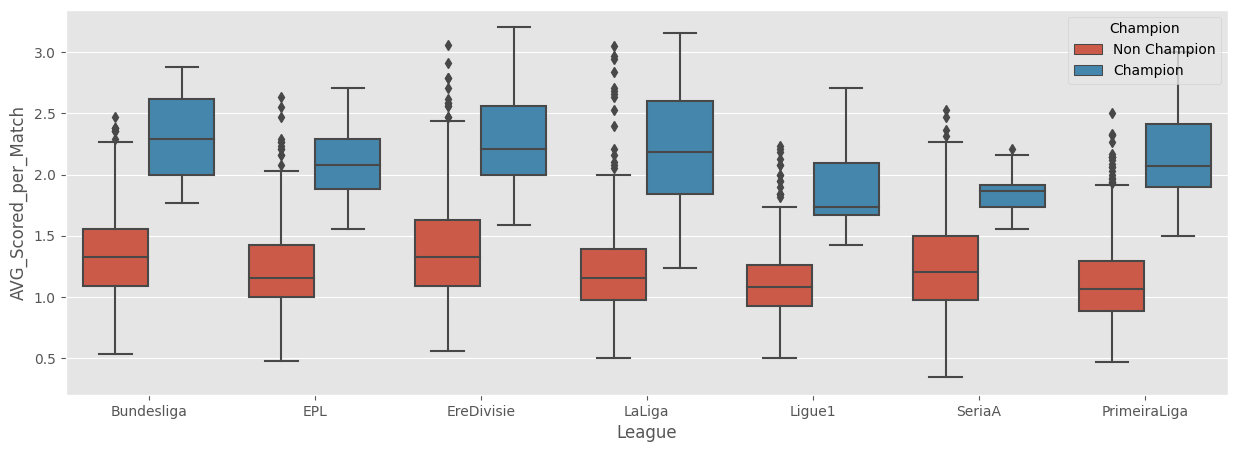

In [12]:
plt.figure(figsize=(15,5))
sns.boxplot(merged_ss_gk,x='League',y='AVG_Scored_per_Match',hue='Champion')
plt.show()

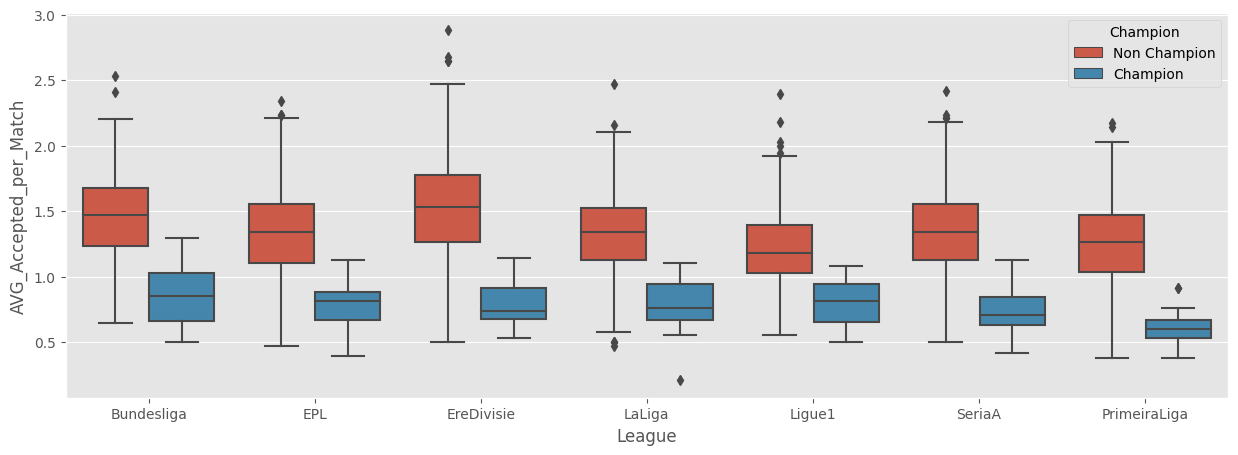

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(merged_ss_gk,x='League',y='AVG_Accepted_per_Match',hue='Champion')
plt.show()

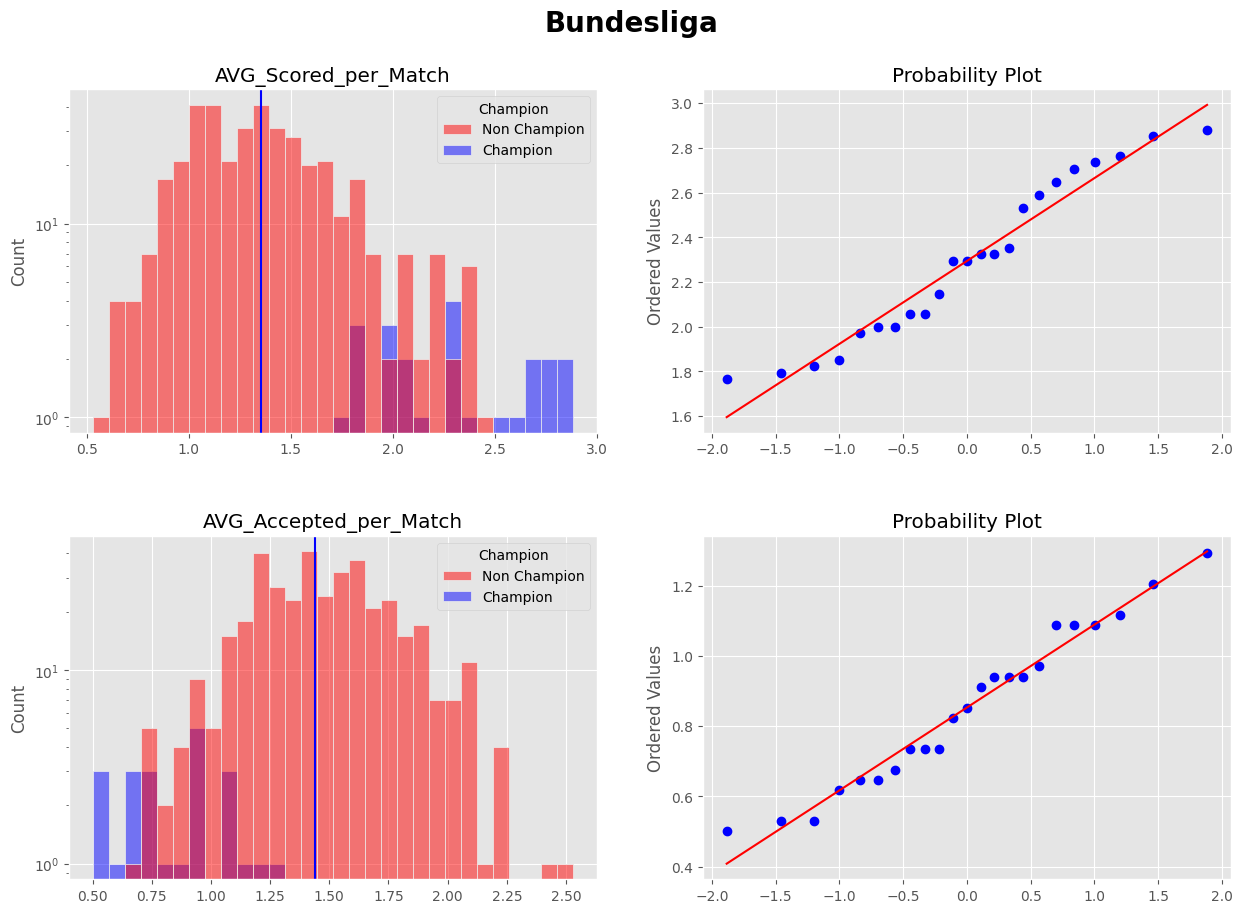

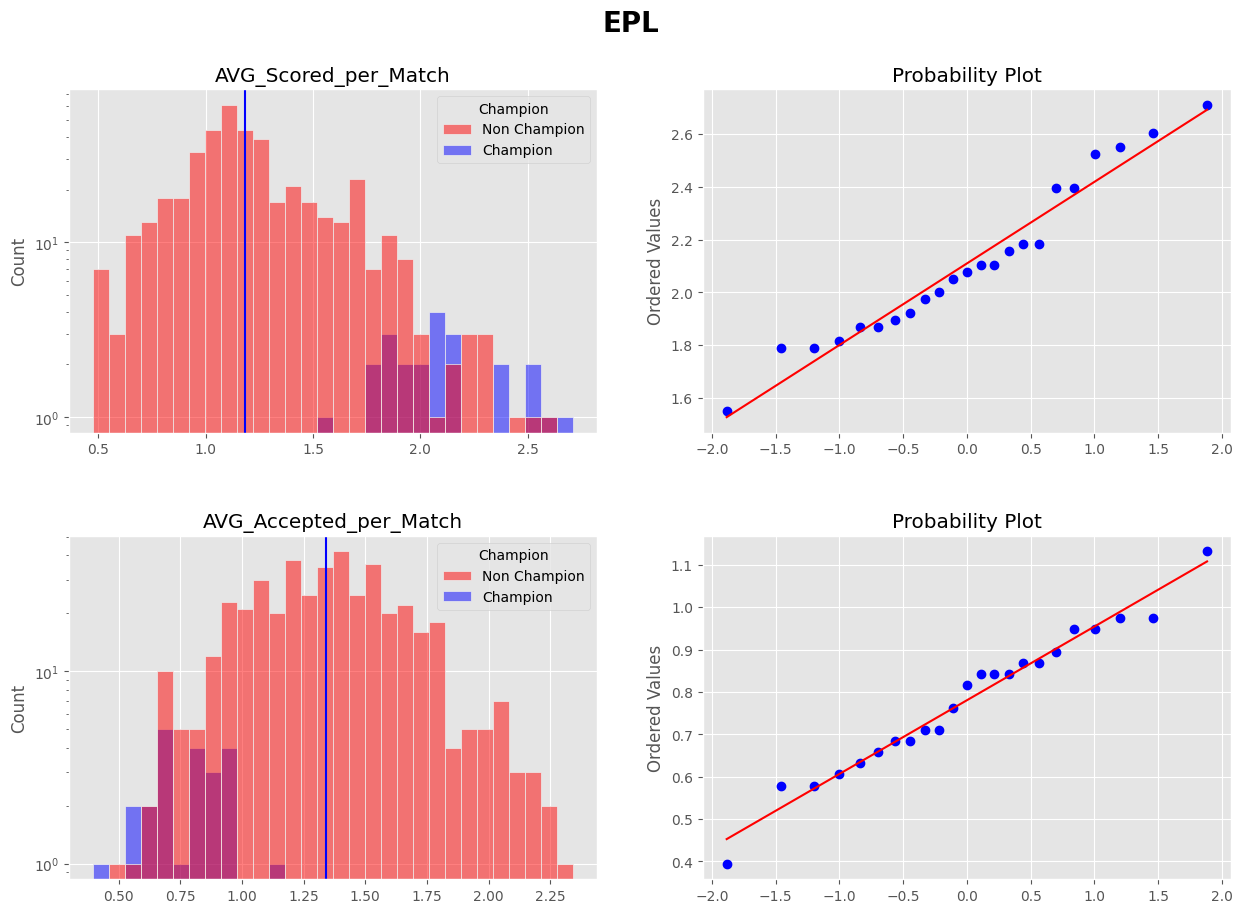

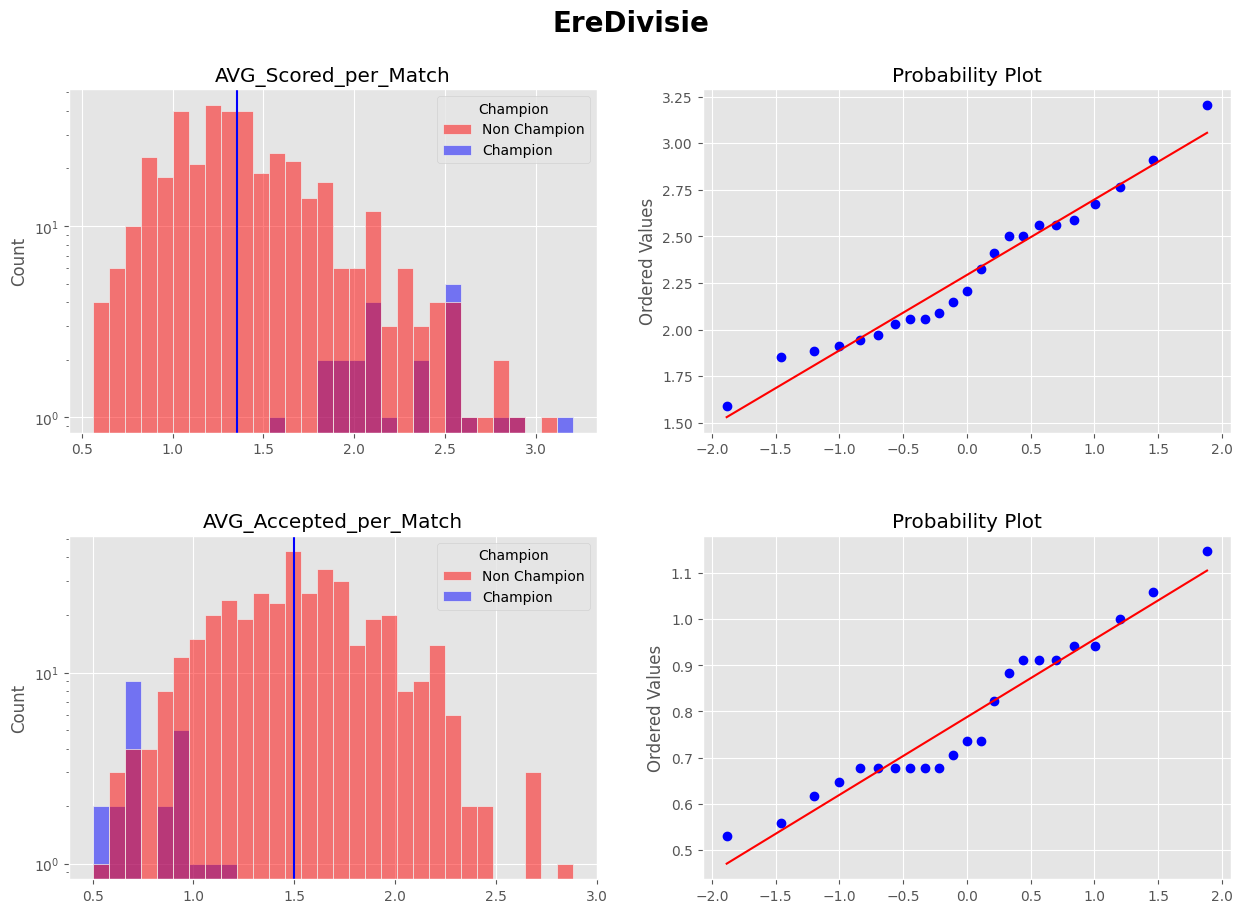

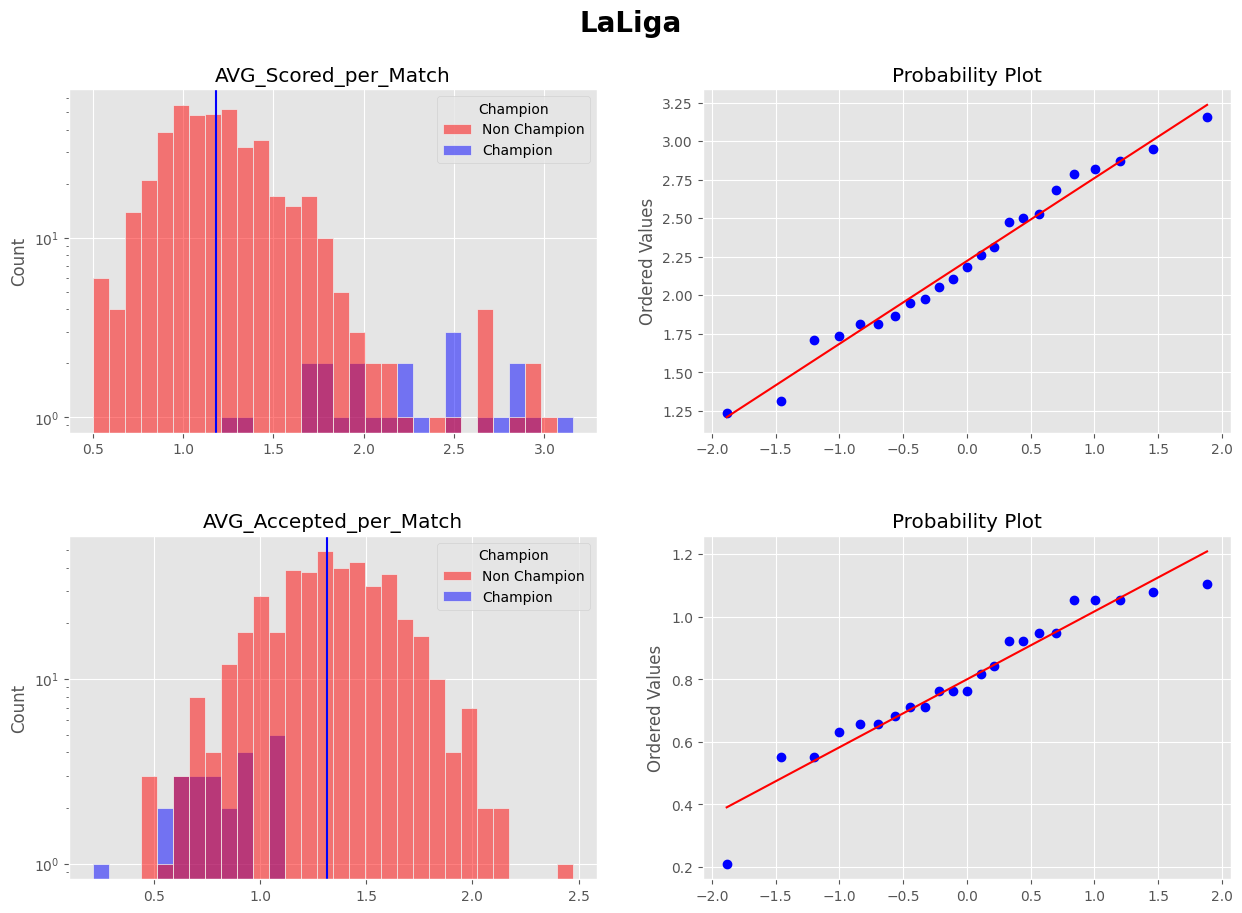

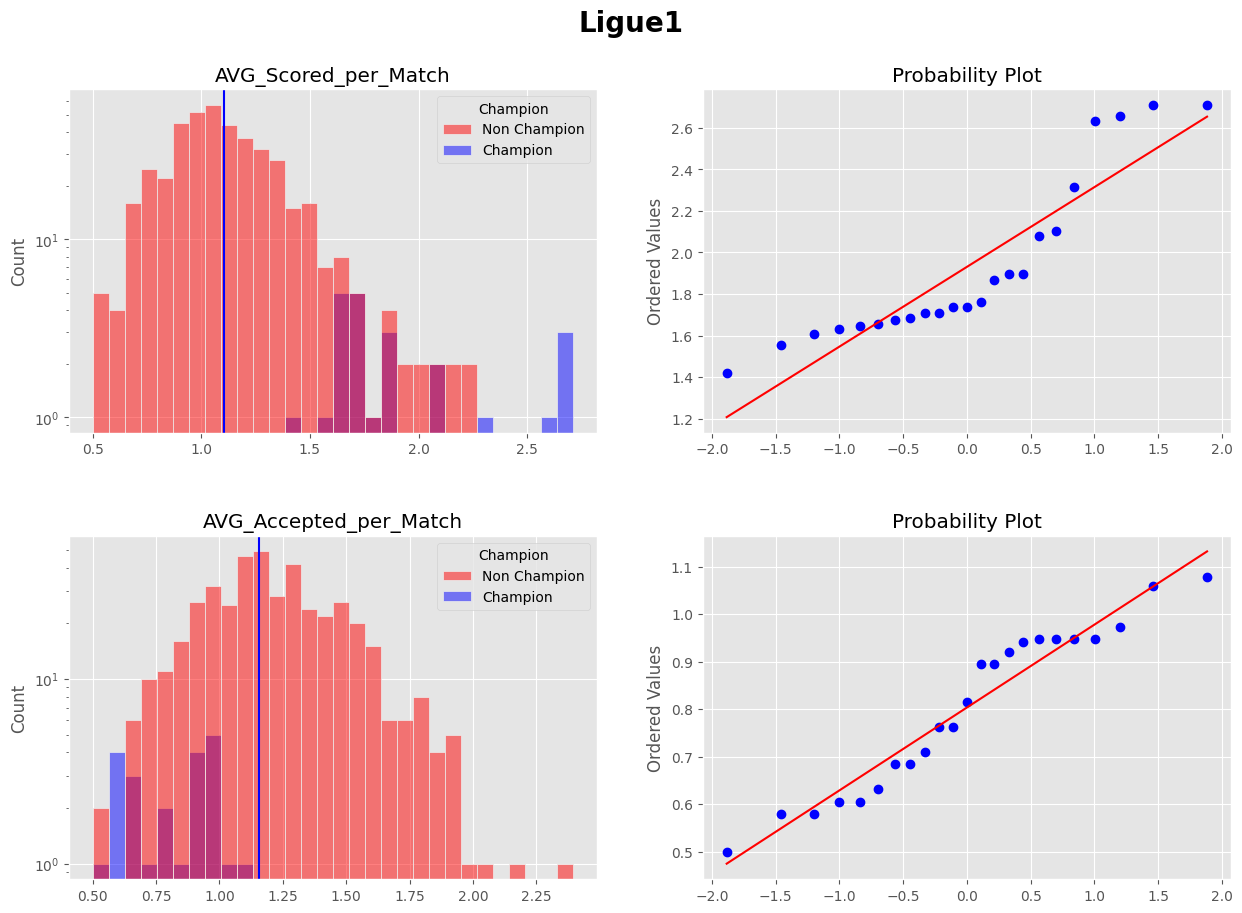

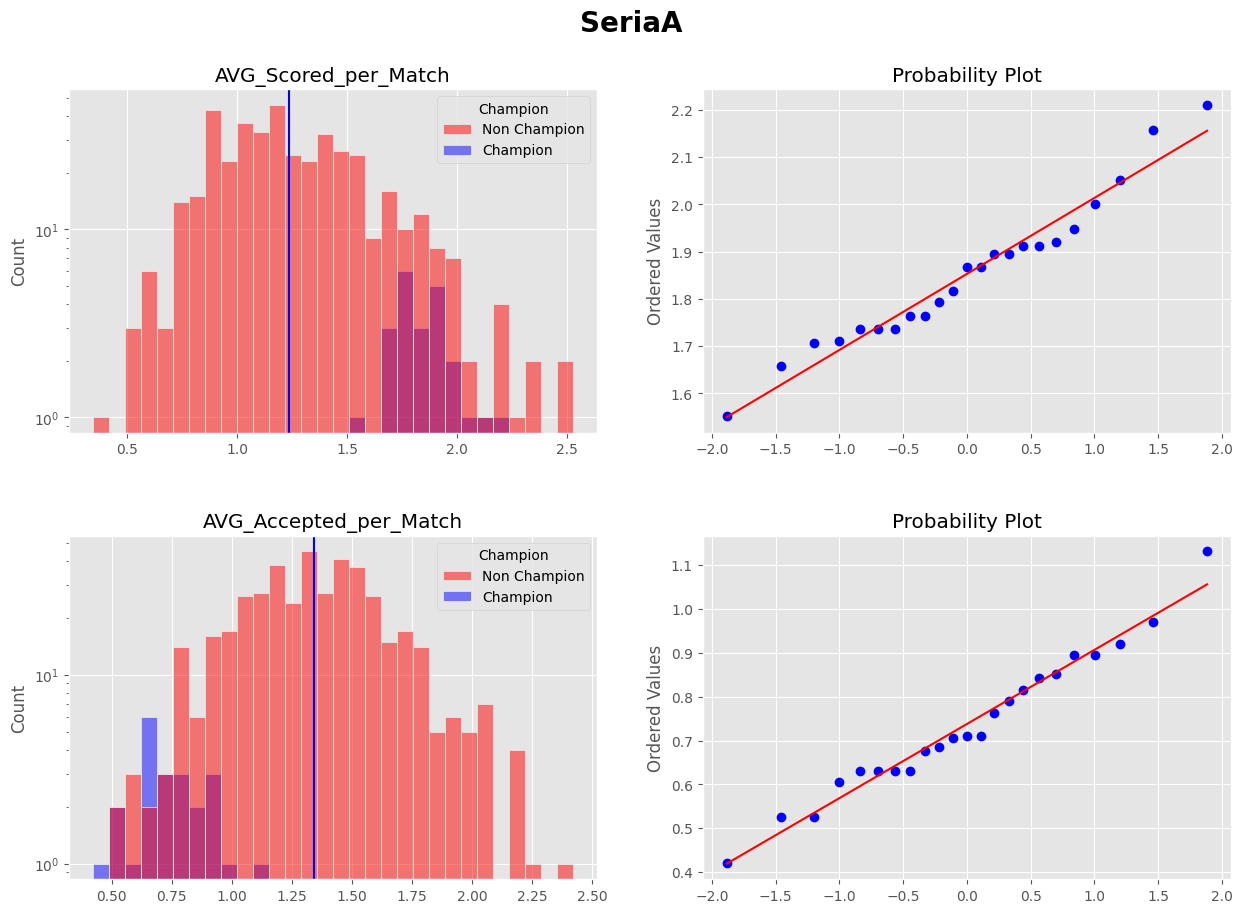

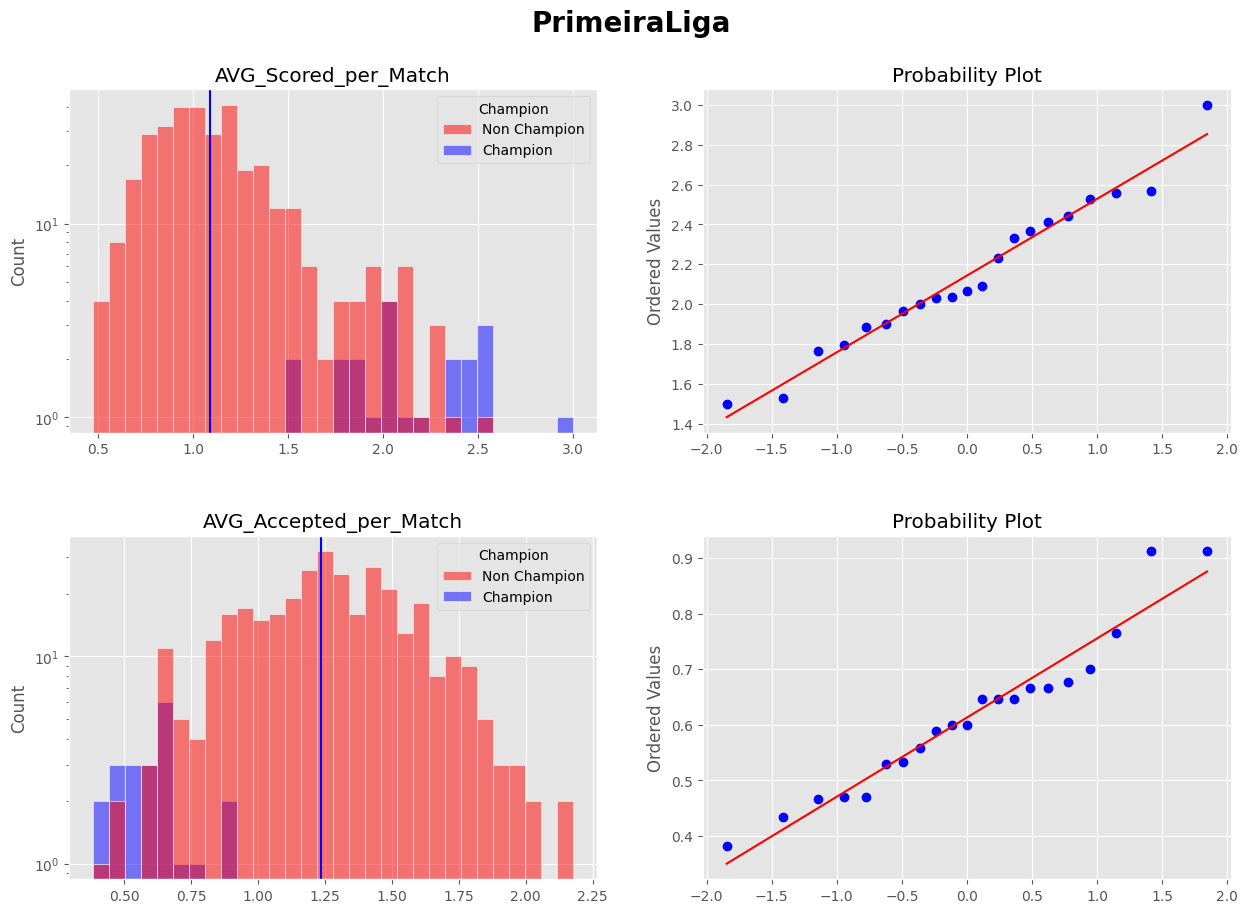

In [14]:
for league in merged_ss_gk['League'].unique():
    
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(15,10))
    filt=merged_ss_gk.query('League==@league')
    
    sns.histplot(filt,x='AVG_Scored_per_Match',bins=30,ax=ax1,hue='Champion',palette=['red','blue'])
    ax1.axvline(filt['AVG_Scored_per_Match'].median(),color='b',label='Median Value')
    ax1.set_title('AVG_Scored_per_Match')
    ax1.set_xlabel('')
    ax1.set_yscale('log')
    
    stats.probplot(filt.query('Champion=="Champion"')['AVG_Scored_per_Match'],dist='norm',plot=ax2)
    stats.probplot(filt.query('Champion=="Not Champion"')['AVG_Scored_per_Match'],dist='norm',plot=ax2)
    ax2.set_xlabel('')
    
    sns.histplot(filt,x='AVG_Accepted_per_Match',bins=30,ax=ax3,hue='Champion',palette=['red','blue'])
    ax3.axvline(filt['AVG_Accepted_per_Match'].median(),color='b',label='Median Value')
    ax3.set_title('AVG_Accepted_per_Match')
    ax3.set_xlabel('')
    ax3.set_yscale('log')
    
    stats.probplot(filt.query('Champion=="Champion"')['AVG_Accepted_per_Match'],dist='norm',plot=ax4)
    stats.probplot(filt.query('Champion=="Not Champion"')['AVG_Accepted_per_Match'],dist='norm',plot=ax4)
    ax4.set_xlabel('')
    
    plt.suptitle(league,size=20,fontweight='bold')
    plt.subplots_adjust(hspace=0.3,top=0.90)
    plt.show()
    print('\n\n\n\n')

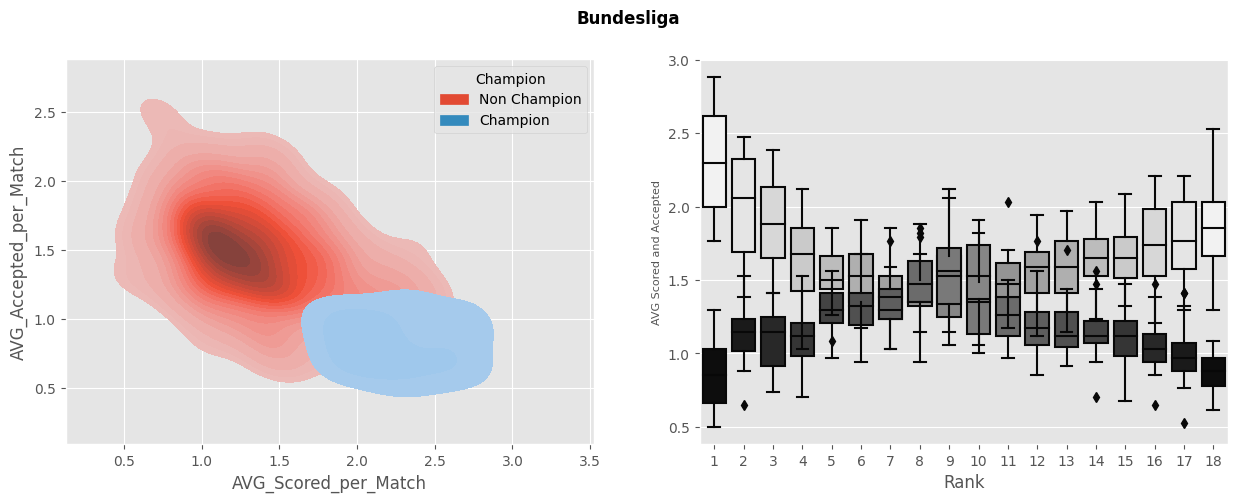

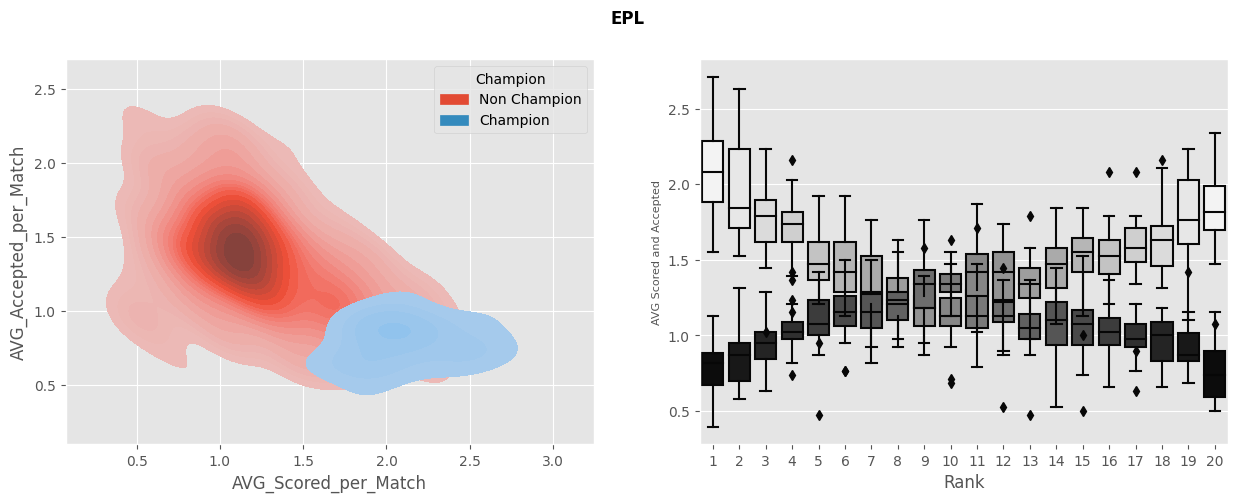

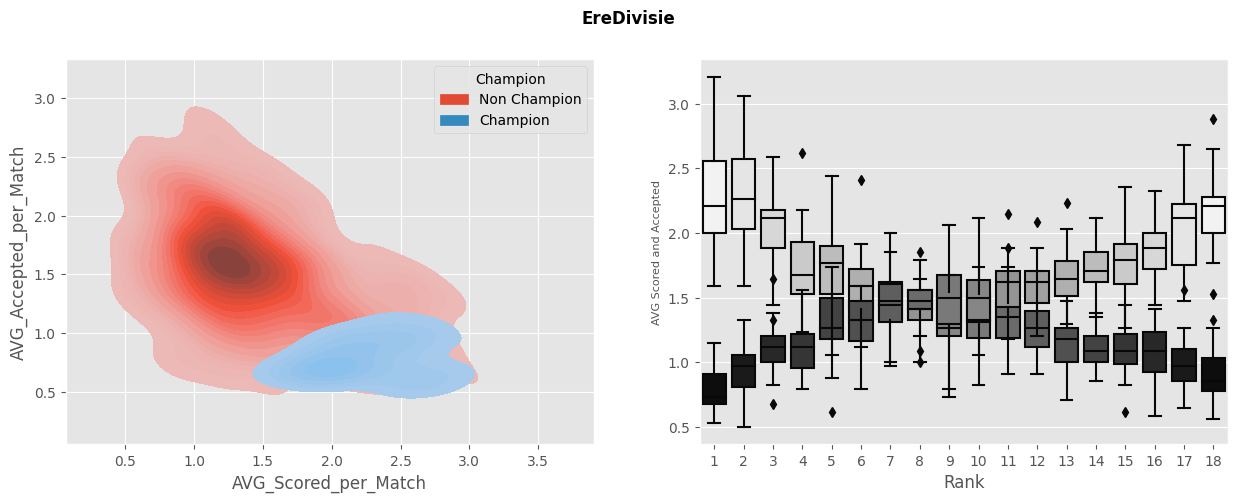

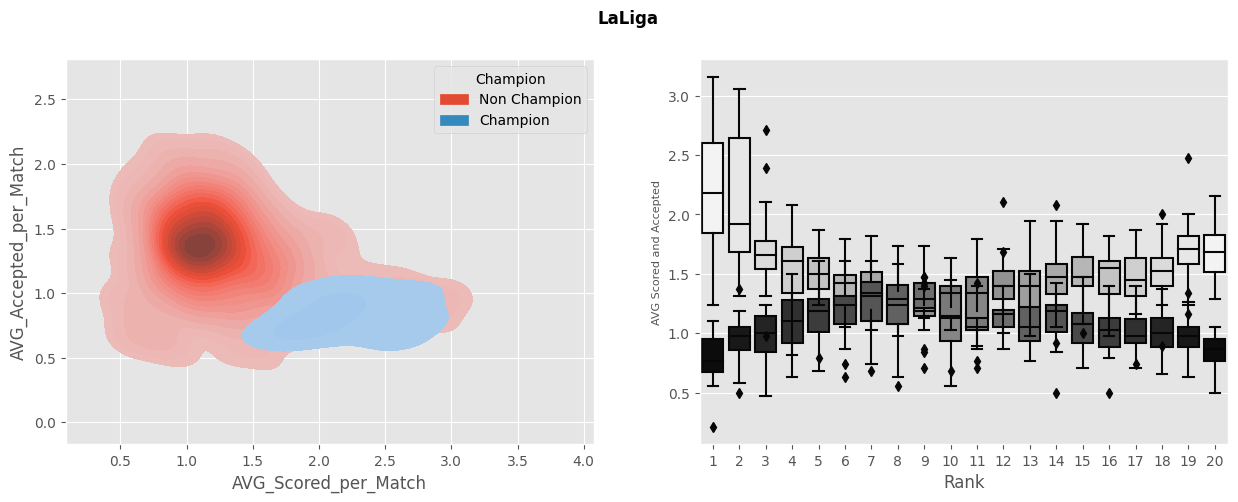

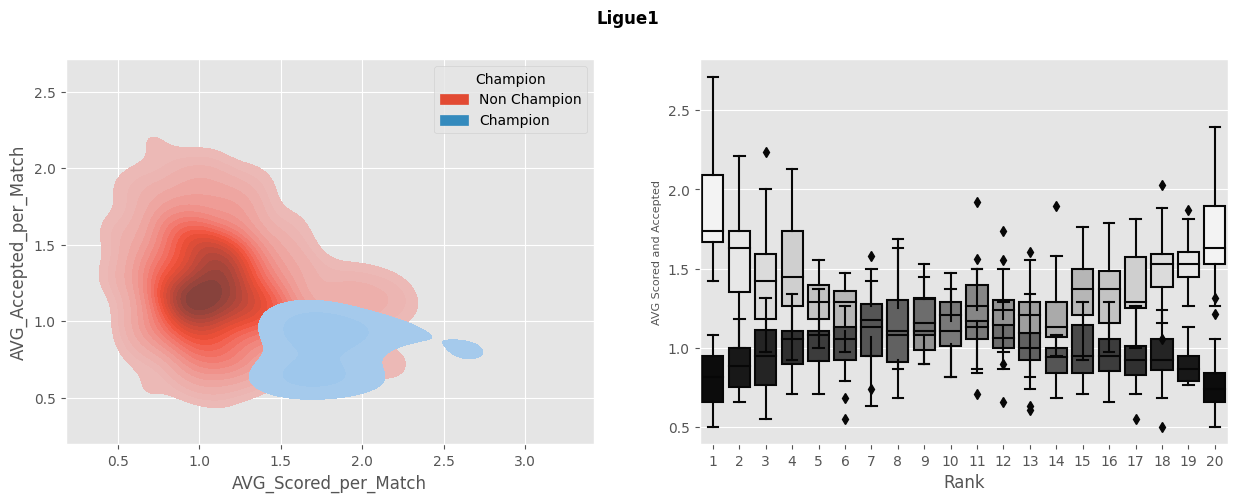

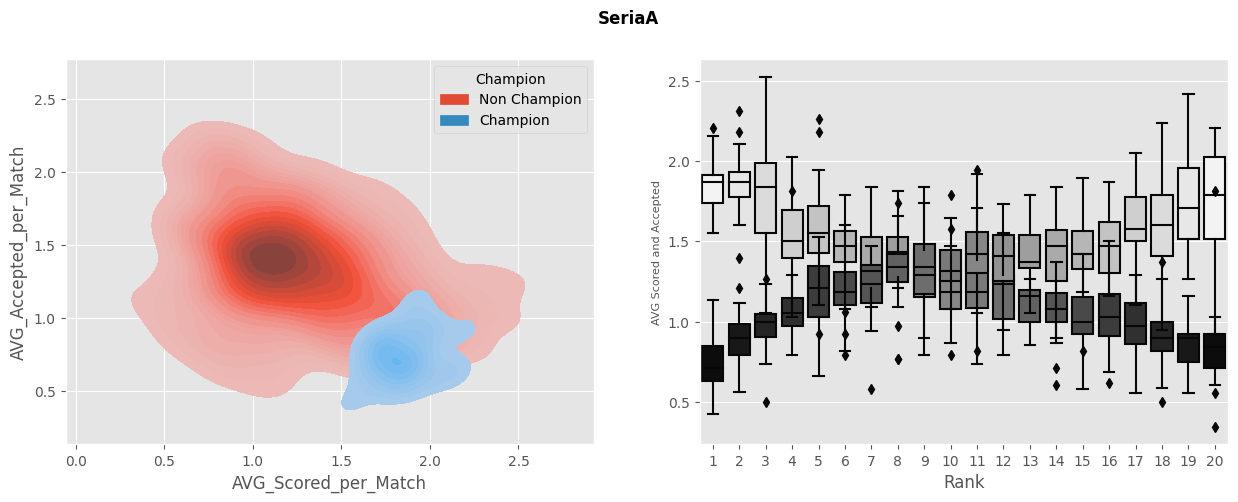

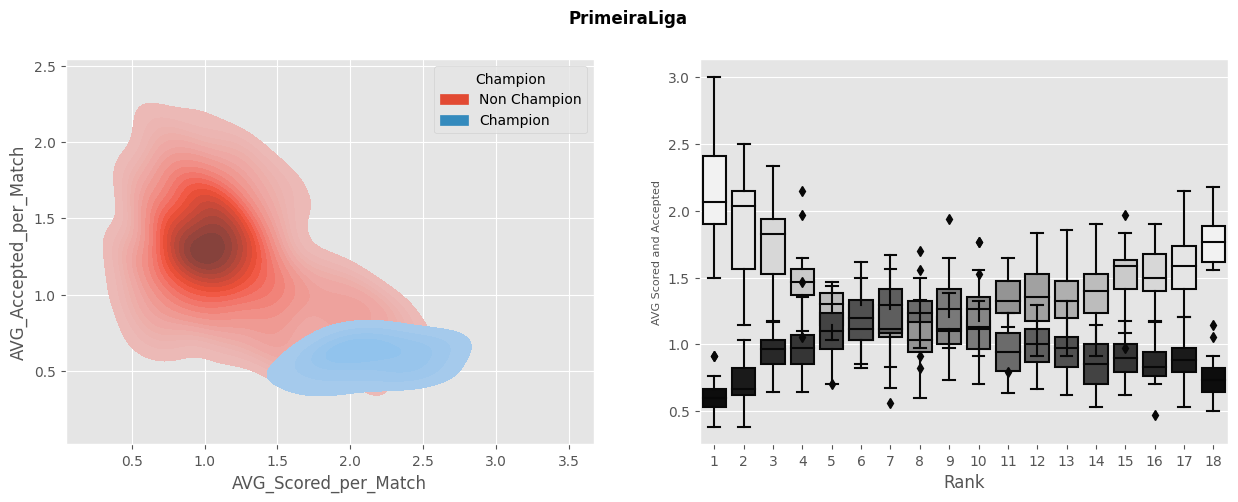

In [15]:
for league in merged_ss_gk['League'].unique():
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    filt=merged_ss_gk.query('League==@league')
    
    sns.kdeplot(filt,x='AVG_Scored_per_Match',y='AVG_Accepted_per_Match',hue='Champion',levels=20,shade=True,ax=ax1)
    
    #sns.lineplot(filt,x='Rank',y='AVG_Scored_per_Match',ci=100,ax=ax2,label='Scored',color='grey')
    #sns.lineplot(filt,x='Rank',y='AVG_Accepted_per_Match',ci=100,ax=ax2,label='Accepted',color='black')
    sns.boxplot(filt,x='Rank',y='AVG_Scored_per_Match',palette='binary')
    sns.boxplot(filt,x='Rank',y='AVG_Accepted_per_Match',palette='gray')
    ax2.set_ylabel('AVG Scored and Accepted',size=8)
    
    ax2.set_xticks(filt['Rank'].unique()-1,filt['Rank'].unique())
    plt.suptitle(league,fontweight='bold')
    plt.show()
    
print('\n\n\n\n')

In [49]:
all_matches

,Season,Date,Time,Comp,Round,Day,Venue,Result,Team,GF,GA,Opponent,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,xG,xGA
0,2000-2001,2000-08-20,NaN,Premier League,Matchweek 1,Sun,Home,W,Manchester Utd,2,0,Newcastle Utd,NaN,NaN,NaN,NaN,Stephen Lodge,Match Report,NaN,NaN,NaN
1,2000-2001,2000-08-22,NaN,Premier League,Matchweek 2,Tue,Away,D,Manchester Utd,1,1,Ipswich Town,NaN,NaN,NaN,NaN,Jeff Winter,Match Report,NaN,NaN,NaN
2,2000-2001,2000-08-26,NaN,Premier League,Matchweek 3,Sat,Away,D,Manchester Utd,2,2,West Ham,NaN,NaN,NaN,NaN,Dermot Gallagher,Match Report,NaN,NaN,NaN
3,2000-2001,2000-09-05,NaN,Premier League,Matchweek 4,Tue,Home,W,Manchester Utd,6,0,Bradford City,NaN,NaN,NaN,NaN,Rob Harris,Match Report,NaN,NaN,NaN
4,2000-2001,2000-09-09,NaN,Premier League,Matchweek 5,Sat,Home,W,Manchester Utd,3,0,Sunderland,NaN,NaN,NaN,NaN,Neale Barry,Match Report,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123653,2022-2023,2023-04-30,15:30,Primeira Liga,Matchweek 30,Sun,Away,NaN,Santa Clara,NaN,NaN,Estoril,NaN,NaN,NaN,NaN,NaN,Head-to-Head,NaN,NaN,NaN
123654,2022-2023,2023-05-07,NaN,Primeira Liga,Matchweek 31,Sun,Home,NaN,Santa Clara,NaN,NaN,Gil Vicente FC,NaN,NaN,NaN,NaN,NaN,Head-to-Head,NaN,NaN,NaN
123655,2022-2023,2023-05-14,NaN,Primeira Liga,Matchweek 32,Sun,Away,NaN,Santa Clara,NaN,NaN,Braga,NaN,NaN,NaN,NaN,NaN,Head-to-Head,NaN,NaN,NaN
123656,2022-2023,2023-05-21,NaN,Primeira Liga,Matchweek 33,Sun,Home,NaN,Santa Clara,NaN,NaN,Portimonense,NaN,NaN,NaN,NaN,NaN,Head-to-Head,NaN,NaN,NaN


In [50]:
leagues=['Premier League','Bundesliga','La Liga','Serie A','Eredivisie','Primeira Liga','Ligue 1']
all_matches=all_matches[all_matches['Comp'].isin(leagues)].reset_index(drop=True) #removing cup competitions and UEFA competitions

all_matches=all_matches.dropna(subset=['GF','GA']).reset_index(drop=True) #removing matches, that have not been taken place yet
all_matches=all_matches[all_matches['GF'].str.contains(' ',regex=True)==False] #removing matches that ended with penalties

In [51]:
all_matches['Points']=all_matches.apply(lambda x:3 if x['GF']>x['GA'] else 1 if x['GF']==x['GA'] else 0, axis=1)

In [52]:
all_matches['CumMatches']=all_matches.groupby(['Comp','Season','Team'])['Date'].cumcount()+1
all_matches['CumPoints']=all_matches.groupby(['Comp','Season','Team'])['Points'].cumsum()

In [53]:
all_matches=pd.merge(all_matches,data,left_on=['Season','Team'],right_on=['Season','Team'])

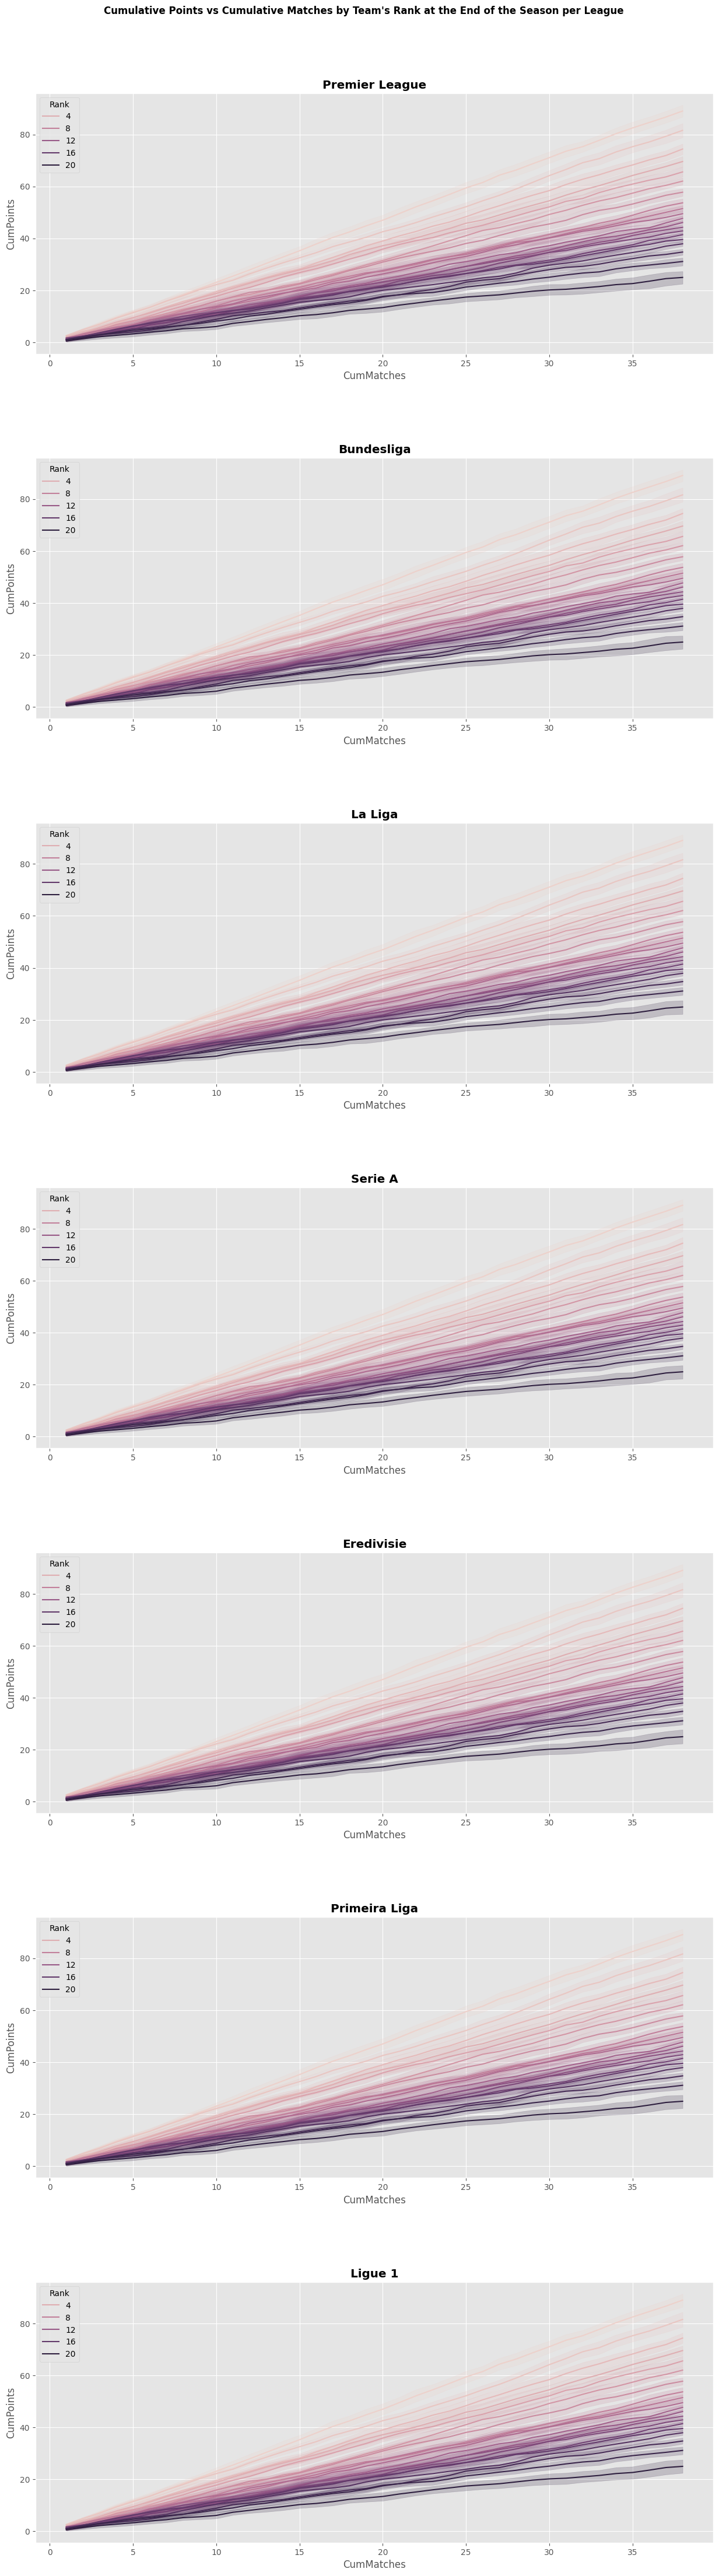

In [59]:
%%time

fig,axes=plt.subplots(7,1,figsize=(15,50))
for comp,ax in zip(all_matches['Comp'].unique(),axes.ravel()):
    sns.lineplot(all_matches.query('Comp=="Premier League"'),x='CumMatches',y='CumPoints',hue='Rank',ax=ax)
    ax.set_title(comp,fontweight='bold')
    
plt.suptitle("Cumulative Points vs Cumulative Matches by Team's Rank at the End of the Season, per League",fontweight='bold')
plt.subplots_adjust(hspace=0.4,top=0.95)
plt.show()

### Predicting whether a team becomes champion or not by number of matches it played and points earned

In [154]:
X=all_matches.query('CumMatches>10')[['CumMatches','CumPoints']]
y=all_matches.query('CumMatches>10')['Rank'].apply(lambda x:1 if x==1 else 0)

X,y

(        CumMatches  CumPoints
 10              11         24
 11              12         27
 12              13         30
 13              14         33
 14              15         36
 ...            ...        ...
 107765          24         15
 107766          25         15
 107767          26         15
 107768          27         15
 107769          28         15
 
 [77590 rows x 2 columns],
 10        1
 11        1
 12        1
 13        1
 14        1
          ..
 107765    0
 107766    0
 107767    0
 107768    0
 107769    0
 Name: Rank, Length: 77590, dtype: int64)

In [155]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [156]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import metrics

In [157]:
model=XGBClassifier()

In [158]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [159]:
train_prediction=model.predict(X_train)
test_prediction=model.predict(X_test)

In [160]:
train_accuracy=metrics.accuracy_score(y_train,train_prediction)
test_accuracy=metrics.accuracy_score(y_test,test_prediction)

print(train_accuracy,test_accuracy)

0.9651211496326846 0.9643639644284058


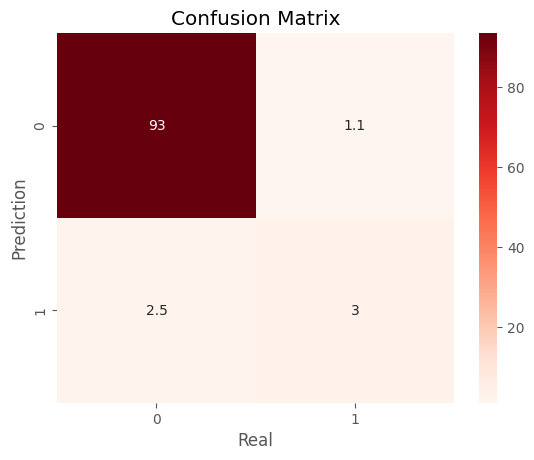

In [161]:
cm=metrics.confusion_matrix(y_test,test_prediction)
sns.heatmap(cm/cm.sum()*100,annot=True,cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.show()